In [49]:

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import re
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
import dataframe_image as dfi

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:

# loading the data into a dataframe
df = pd.read_excel('../../data/test/1000_random_rows_24_07_2020.xlsx')
display(df)

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count
0,2020-07-24T22:09:10Z,Minnesota,"@harconsulting Bet trump backs out of it, when...",Twitter Web App,64,en,1,1,False,26181,28653,1,48506,68822
1,2020-07-21T00:19:06Z,Texas,@BillOReilly Why would schools being closed en...,Twitter Web App,280,en,0,0,False,216,1348,2,6905,15218
2,2020-07-24T05:14:11Z,Colorado,@EliTheAverage @TheRickWilson We don't even kn...,Twitter for Android,278,en,0,0,False,866,454,17,2027,174
3,2020-07-24T21:41:30Z,South Carolina,"If you guys vote anywhere near Joe Biden, it’l...",Twitter for iPhone,130,en,1,1,False,976,813,1,26913,25877
4,2020-07-23T16:47:25Z,West Virginia,Social Media Accuses Trump’s Federal Agents Of...,Twitter Web App,202,en,0,0,False,262,1114,10,40160,4607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2020-07-23T13:29:32Z,West Virginia,@real_defender @JoeBiden Tell another lie you ...,Twitter for Android,148,en,1,0,False,3639,4435,3,25773,24254
996,2020-07-24T05:52:51Z,New York,"I completely agree, so Trump shouldn’t take an...",Twitter for iPhone,111,en,1,0,True,2133,519,22,9410,12936
997,2020-07-24T13:06:55Z,Vermont,Rachel Maddow reads from court transcripts and...,Twitter for iPhone,274,en,1,0,False,4126,5000,510,140166,270691
998,2020-07-23T17:34:15Z,Alabama,"If this is happening now,or last night technic...",Twitter for iPhone,271,en,0,0,True,44,165,1,5139,2147


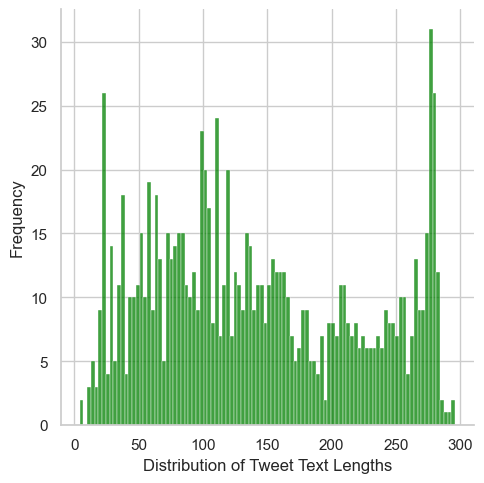

In [80]:
#adding an extra column as this is the columsn that will appear in the dataset we gave to LLM, we can of course adapt this 
# just depends which analysis we will be doing first 

df['cleaned_text'] = df['text']
# creating a new column containing the length of each headline text that is larger than 0
non_empty_lengths = df[(df['cleaned_text'].notnull()) & (df['display_text_width'] > 0)]['display_text_width']
# visualising the length distribution 

sns.set(rc={'figure.figsize':(14,11)})
sns.set(style="whitegrid")
sns.displot(non_empty_lengths, kde=False, color='green', bins=100)


plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Distribution of Tweet Text Lengths', fontsize=12)
plt.grid(True)


plt.show()

## Pre-processing the text

In [52]:
#removing line spacing and 'at' symbols
df['cleaned_text'] = df['cleaned_text'].replace('\n',' ', regex=True)
df['cleaned_text'] = df['cleaned_text'].replace('\xa0',' ', regex=True)


In [53]:
'''
# removing all emojis
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
                      
    return re.sub(emoj, '', data)


df['cleaned_text'] = df['cleaned_text'].apply(remove_emojis)
'''

'\n# removing all emojis\ndef remove_emojis(data):\n    emoj = re.compile("["\n        u"😀-🙏"  # emoticons\n        u"🌀-🗿"  # symbols & pictographs\n        u"🚀-\U0001f6ff"  # transport & map symbols\n        u"\U0001f1e0-🇿"  # flags (iOS)\n        u"─-⯯"  # chinese char\n        u"✂-➰"\n        u"Ⓜ-🉑"\n        u"🤦-🤷"\n        u"𐀀-\U0010ffff"\n        u"♀-♂" \n        u"☀-⭕"\n        u"\u200d"\n        u"⏏"\n        u"⏩"\n        u"⌚"\n        u"️"  # dingbats\n        u"〰"\n                      "]+", re.UNICODE)\n                      \n    return re.sub(emoj, \'\', data)\n\n\ndf[\'cleaned_text\'] = df[\'cleaned_text\'].apply(remove_emojis)\n'

In [54]:
import re

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
                      
    return re.sub(emoj, '', str(data))  # Convert data to string before removing emojis

# Apply remove_emojis function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_emojis)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0       Since trump cancelled his convention in Jack...
1      9 year old died in Florida from COVID this we...
2     If trump decides he won’t leave the White Hous...
3     Ao now we have "the Trump virus" and the "Skan...
4      That two seconds I spend trying to ace this q...
                            ...                        
95     This is just another example of why Trump the...
96         In the trump orbit, nothing is unimaginable.
97      I'm disappointed but not surprised by Melani...
98      Who is the interviewer &amp; why do they kee...
99      1] That's what I was alluding to before. Pro...
Name: cleaned_text, Length: 100, dtype: object


In [55]:


print(df['cleaned_text'].head(10))


0      Since trump cancelled his convention in Jack...
1     9 year old died in Florida from COVID this we...
2    If trump decides he won’t leave the White Hous...
3    Ao now we have "the Trump virus" and the "Skan...
4     That two seconds I spend trying to ace this q...
5     Poor fact checking. According to you own sour...
6       Goya bean can claps back at Ivanka Trump  via 
7     Add sabotage to the corruption, grifting and ...
8    Declassified Documents Show FBI Used ‘Defensiv...
9      This is video of an America trying to get ou...
Name: cleaned_text, dtype: object


In [56]:
'''
#removing numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
df['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)
'''

"\n#removing numbers\ndef remove_numbers(text):\n    return re.sub(r'\\d+', '', text)\ndf['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)\n"

In [57]:
import re

def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    else:
        return text

# Apply remove_numbers function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_numbers)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)



0       Since trump cancelled his convention in Jack...
1       year old died in Florida from COVID this wee...
2     If trump decides he won’t leave the White Hous...
3     Ao now we have "the Trump virus" and the "Skan...
4      That two seconds I spend trying to ace this q...
                            ...                        
95     This is just another example of why Trump the...
96         In the trump orbit, nothing is unimaginable.
97      I'm disappointed but not surprised by Melani...
98      Who is the interviewer &amp; why do they kee...
99      ] That's what I was alluding to before. Prot...
Name: cleaned_text, Length: 100, dtype: object


In [58]:
'''
#removing punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
'''


"\n#removing punctuation\ndef remove_punctuation(text):\n    return text.translate(str.maketrans('', '', string.punctuation))\n\n\ndf['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)\n"

In [59]:
import string

def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    elif isinstance(text, (int, float)):
        return str(text).translate(str.maketrans('', '', string.punctuation))
    else:
        return text  # Return as is if not a string, int, or float

# Apply remove_punctuation function to 'cleaned_text' column
try:
    df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuation)
    print(df['cleaned_text'])
except Exception as e:
    print("An error occurred:", e)


0       Since trump cancelled his convention in Jack...
1       year old died in Florida from COVID this wee...
2     If trump decides he won’t leave the White Hous...
3     Ao now we have the Trump virus and the Skank flu 
4      That two seconds I spend trying to ace this q...
                            ...                        
95     This is just another example of why Trump the...
96           In the trump orbit nothing is unimaginable
97      Im disappointed but not surprised by Melania...
98      Who is the interviewer amp why do they keep ...
99       Thats what I was alluding to before Protest...
Name: cleaned_text, Length: 100, dtype: object


In [60]:
# manually replacing synonyms and words
'''
df['review_text_english'] = df['review_text_english'].str.replace(r'\b(?:bicycle|bikes)\b', 'bike', case=False, regex=True)

df['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)

df['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)
df['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)
'''

"\ndf['review_text_english'] = df['review_text_english'].str.replace(r'\x08(?:bicycle|bikes)\x08', 'bike', case=False, regex=True)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('places', 'place', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('parkeerplaats', 'parking', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('easily', 'easy', case=False)\n\ndf['review_text_english'] = df['review_text_english'].str.replace('authentica', 'authentic', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('genial', 'great', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('pŕ', 'pr', case=False)\ndf['review_text_english'] = df['review_text_english'].str.replace('combinatie', 'combination', case=False)\n"

1. case-normalization


In [61]:
text_list = df['cleaned_text'].tolist()

# case normalization function
def case_normalization(text):
    return text.lower()

# apply case normalization to each element of the text list
normalized_text_list = [case_normalization(word) for word in text_list]

print(normalized_text_list)


['  since trump cancelled his convention in jacksonville due to health concerns lets see his hypocrite followers say how wonderful he is to care about them and their health while theyve been bitching about stuff being closed and cancelled and corona being a hoax all this time', '  year old died in florida from covid this week i know you don’t give a shit because it’s not your kid but my kid won’t be attending school no matter what trump and his dumbass cult say', 'if trump decides he won’t leave the white house leave him and melanie there if she doesn’t kill him let him wander around and mutter to himself about how perfect he is we can set biden and a legitimate thoughtful government up elsewhere let’s put barr in with him', 'ao now we have the trump virus and the skank flu ', ' that two seconds i spend trying to ace this quiz each time tho   they should put that shit into trump’s walter reed test', ' poor fact checking according to you own sources in january  he made general statement

## Visualisation

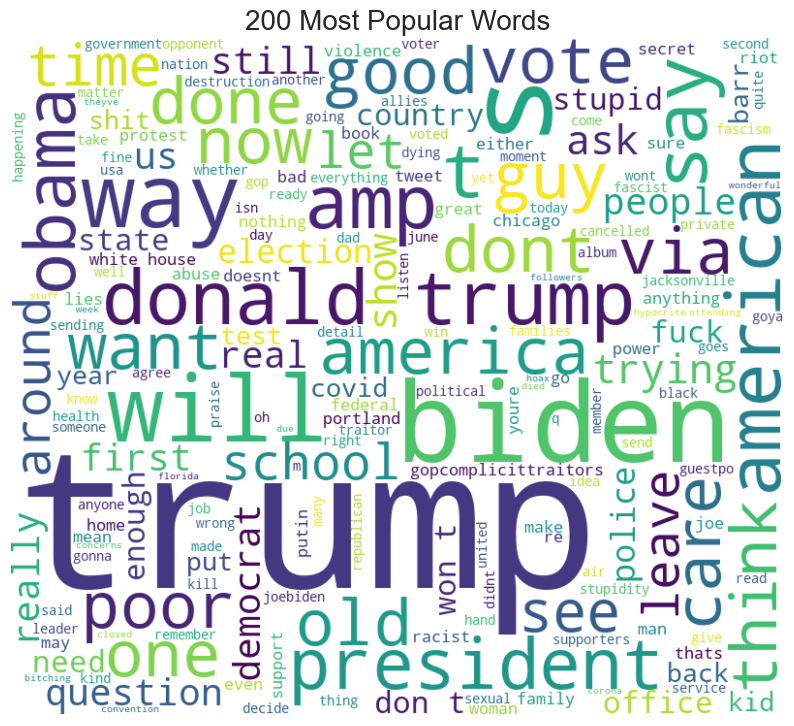

In [62]:
# words visualisation with a wordcloud
concatenated_text = ' '.join(normalized_text_list)
# generating
wordcloud = WordCloud(width=800, height=700, max_words=200, background_color='white').generate(concatenated_text)

# plotting the WordCloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('200 Most Popular Words', size= 20)
plt.show()

## Further pre-processing

2. tokenization

In [63]:
def tokenization(text):
    return text.split()
    
tokenized_text_list = [tokenization(word) for word in normalized_text_list]

print(tokenized_text_list)

[['since', 'trump', 'cancelled', 'his', 'convention', 'in', 'jacksonville', 'due', 'to', 'health', 'concerns', 'lets', 'see', 'his', 'hypocrite', 'followers', 'say', 'how', 'wonderful', 'he', 'is', 'to', 'care', 'about', 'them', 'and', 'their', 'health', 'while', 'theyve', 'been', 'bitching', 'about', 'stuff', 'being', 'closed', 'and', 'cancelled', 'and', 'corona', 'being', 'a', 'hoax', 'all', 'this', 'time'], ['year', 'old', 'died', 'in', 'florida', 'from', 'covid', 'this', 'week', 'i', 'know', 'you', 'don’t', 'give', 'a', 'shit', 'because', 'it’s', 'not', 'your', 'kid', 'but', 'my', 'kid', 'won’t', 'be', 'attending', 'school', 'no', 'matter', 'what', 'trump', 'and', 'his', 'dumbass', 'cult', 'say'], ['if', 'trump', 'decides', 'he', 'won’t', 'leave', 'the', 'white', 'house', 'leave', 'him', 'and', 'melanie', 'there', 'if', 'she', 'doesn’t', 'kill', 'him', 'let', 'him', 'wander', 'around', 'and', 'mutter', 'to', 'himself', 'about', 'how', 'perfect', 'he', 'is', 'we', 'can', 'set', 'bid

3. stopwords removal 

In [64]:

custom_stopwords = ['€']

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords or []))  # adding the custom stopwords and english
    return [token for token in tokens if token not in stop_words]

tokens = [remove_stopwords(word) for word in tokenized_text_list]
print(tokens)

[['since', 'trump', 'cancelled', 'convention', 'jacksonville', 'due', 'health', 'concerns', 'lets', 'see', 'hypocrite', 'followers', 'say', 'wonderful', 'care', 'health', 'theyve', 'bitching', 'stuff', 'closed', 'cancelled', 'corona', 'hoax', 'time'], ['year', 'old', 'died', 'florida', 'covid', 'week', 'know', 'don’t', 'give', 'shit', 'it’s', 'kid', 'kid', 'won’t', 'attending', 'school', 'matter', 'trump', 'dumbass', 'cult', 'say'], ['trump', 'decides', 'won’t', 'leave', 'white', 'house', 'leave', 'melanie', 'doesn’t', 'kill', 'let', 'wander', 'around', 'mutter', 'perfect', 'set', 'biden', 'legitimate', 'thoughtful', 'government', 'elsewhere', 'let’s', 'put', 'barr'], ['ao', 'trump', 'virus', 'skank', 'flu'], ['two', 'seconds', 'spend', 'trying', 'ace', 'quiz', 'time', 'tho', 'put', 'shit', 'trump’s', 'walter', 'reed', 'test'], ['poor', 'fact', 'checking', 'according', 'sources', 'january', 'made', 'general', 'statements', 'derogatory', 'president', 'trump'], ['goya', 'bean', 'claps', 

In [65]:
# transforming into a string to create a model
tokens = [str(token) for token in tokens]
print(tokens)
tokens = [string.strip("'") for string in tokens if string.strip("[]").strip("'")]

["['since', 'trump', 'cancelled', 'convention', 'jacksonville', 'due', 'health', 'concerns', 'lets', 'see', 'hypocrite', 'followers', 'say', 'wonderful', 'care', 'health', 'theyve', 'bitching', 'stuff', 'closed', 'cancelled', 'corona', 'hoax', 'time']", "['year', 'old', 'died', 'florida', 'covid', 'week', 'know', 'don’t', 'give', 'shit', 'it’s', 'kid', 'kid', 'won’t', 'attending', 'school', 'matter', 'trump', 'dumbass', 'cult', 'say']", "['trump', 'decides', 'won’t', 'leave', 'white', 'house', 'leave', 'melanie', 'doesn’t', 'kill', 'let', 'wander', 'around', 'mutter', 'perfect', 'set', 'biden', 'legitimate', 'thoughtful', 'government', 'elsewhere', 'let’s', 'put', 'barr']", "['ao', 'trump', 'virus', 'skank', 'flu']", "['two', 'seconds', 'spend', 'trying', 'ace', 'quiz', 'time', 'tho', 'put', 'shit', 'trump’s', 'walter', 'reed', 'test']", "['poor', 'fact', 'checking', 'according', 'sources', 'january', 'made', 'general', 'statements', 'derogatory', 'president', 'trump']", "['goya', 'bea

5. stemming and lemmatization

In [66]:

# initialising stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# stemming
stemmed_words = [stemmer.stem(token) for token in tokens]

# lemmatization
lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]


print("Stemmed Tokens:", stemmed_words)
print("Lemmatized Tokens:", lemmatized_words)
tokens = lemmatized_words

Stemmed Tokens: ["['since', 'trump', 'cancelled', 'convention', 'jacksonville', 'due', 'health', 'concerns', 'lets', 'see', 'hypocrite', 'followers', 'say', 'wonderful', 'care', 'health', 'theyve', 'bitching', 'stuff', 'closed', 'cancelled', 'corona', 'hoax', 'time']", "['year', 'old', 'died', 'florida', 'covid', 'week', 'know', 'don’t', 'give', 'shit', 'it’s', 'kid', 'kid', 'won’t', 'attending', 'school', 'matter', 'trump', 'dumbass', 'cult', 'say']", "['trump', 'decides', 'won’t', 'leave', 'white', 'house', 'leave', 'melanie', 'doesn’t', 'kill', 'let', 'wander', 'around', 'mutter', 'perfect', 'set', 'biden', 'legitimate', 'thoughtful', 'government', 'elsewhere', 'let’s', 'put', 'barr']", "['ao', 'trump', 'virus', 'skank', 'flu']", "['two', 'seconds', 'spend', 'trying', 'ace', 'quiz', 'time', 'tho', 'put', 'shit', 'trump’s', 'walter', 'reed', 'test']", "['poor', 'fact', 'checking', 'according', 'sources', 'january', 'made', 'general', 'statements', 'derogatory', 'president', 'trump']"

# Analysis

1. Bag of words 

In [67]:
def bag_of_words(tokens):
    return Counter(tokens)

bag_of_words(tokens)

Counter({"['since', 'trump', 'cancelled', 'convention', 'jacksonville', 'due', 'health', 'concerns', 'lets', 'see', 'hypocrite', 'followers', 'say', 'wonderful', 'care', 'health', 'theyve', 'bitching', 'stuff', 'closed', 'cancelled', 'corona', 'hoax', 'time']": 1,
         "['year', 'old', 'died', 'florida', 'covid', 'week', 'know', 'don’t', 'give', 'shit', 'it’s', 'kid', 'kid', 'won’t', 'attending', 'school', 'matter', 'trump', 'dumbass', 'cult', 'say']": 1,
         "['trump', 'decides', 'won’t', 'leave', 'white', 'house', 'leave', 'melanie', 'doesn’t', 'kill', 'let', 'wander', 'around', 'mutter', 'perfect', 'set', 'biden', 'legitimate', 'thoughtful', 'government', 'elsewhere', 'let’s', 'put', 'barr']": 1,
         "['ao', 'trump', 'virus', 'skank', 'flu']": 1,
         "['two', 'seconds', 'spend', 'trying', 'ace', 'quiz', 'time', 'tho', 'put', 'shit', 'trump’s', 'walter', 'reed', 'test']": 1,
         "['poor', 'fact', 'checking', 'according', 'sources', 'january', 'made', 'general'

# Modelling

In [68]:
# preparing embeddings
sentence_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
embeddings = sentence_model.encode(tokens, show_progress_bar=False)

# training BERTopic
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=16, nr_topics=11)
review_topics, _ = model.fit_transform(tokens)

# running the visualization with the original embeddings
model.visualize_documents(tokens, embeddings=embeddings)

# reducing dimensionality of embeddings
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)



2024-03-24 10:49:44,374 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 4/4 [00:00<00:00, 24.35it/s]
2024-03-24 10:49:45,807 - BERTopic - Embedding - Completed ✓
2024-03-24 10:49:45,807 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-24 10:49:51,103 - BERTopic - Dimensionality - Completed ✓
2024-03-24 10:49:51,104 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-24 10:49:51,125 - BERTopic - Cluster - Completed ✓
2024-03-24 10:49:51,126 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-24 10:49:51,148 - BERTopic - Representation - Completed ✓
2024-03-24 10:49:51,149 - BERTopic - Topic reduction - Reducing number of topics
2024-03-24 10:49:51,151 - BERTopic - Topic reduction - Reduced number of topics from 1 to 1


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

# get topic vectors
topic_vectors = model.transform(tokens)

# compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(topic_vectors)

# Display the similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_matrix)

Batches: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]
2024-03-24 10:51:21,379 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-03-24 10:51:21,388 - BERTopic - Dimensionality - Completed ✓
2024-03-24 10:51:21,389 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-03-24 10:51:21,392 - BERTopic - Cluster - Completed ✓


Cosine Similarity Matrix:
[[1. 0.]
 [0. 0.]]


In [70]:
model.visualize_documents(tokens, reduced_embeddings=reduced_embeddings)

Topic Extraction and Representation

In [71]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

frequency = model.get_topic_info()
print("Number of topics: {}".format( len(frequency)))
display(frequency)
dfi.export(frequency, 'dataframe_topics.png')

Number of topics: 1


,Topic,Count,Name,Representation,Representative_Docs
0,-1,98,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't..."


-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [72]:
model.get_topic(0)

False

In [73]:
model.get_document_info(tokens)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"['since', 'trump', 'cancelled', 'convention', ...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
1,"['year', 'old', 'died', 'florida', 'covid', 'w...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
2,"['trump', 'decides', 'won’t', 'leave', 'white'...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
3,"['ao', 'trump', 'virus', 'skank', 'flu']",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
4,"['two', 'seconds', 'spend', 'trying', 'ace', '...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
...,...,...,...,...,...,...,...,...
93,"['another', 'example', 'trump', 'criminal', 'c...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
94,"['trump', 'orbit', 'nothing', 'unimaginable']",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
95,"['im', 'disappointed', 'surprised', 'melania',...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False
96,"['interviewer', 'amp', 'keep', 'scheduling', '...",-1,-1_trump_biden_way_trumps,"[trump, biden, way, trumps, amp, would, like, ...","[['happening', 'usa', 'trump’s', 'america', 't...",trump - biden - way - trumps - amp - would - l...,0.0,False


Top terms and c-TF-IDF scores

In [74]:
a_topic = frequency.iloc[1]["Topic"] # selecting the 1st topic
model.get_topic(a_topic) # showing the words and their c-TF-IDF scores

IndexError: single positional indexer is out-of-bounds

Topic visualisation


In [ ]:

model.visualize_barchart(top_n_topics=17, n_words= 10, width = 300, height = 350)

In [ ]:
model.visualize_topics()

In [ ]:
# Calculate the percentage representation of topics

your_docs = tokens
topic_counts = Counter(review_topics)
total_documents = len(your_docs)
topic_percentages = {topic: count / total_documents * 100 for topic, count in topic_counts.items()}
topic_percentages = {topic: round(count / total_documents * 100, 2) for topic, count in topic_counts.items()}

# Create a DataFrame from the topic percentages
df_topic_percentages = pd.DataFrame(list(topic_percentages.items()), columns=['Topic', 'Percentage of documents in a topic'])
df_topic_percentages = df_topic_percentages.sort_values(by='Topic', ascending=True)
df_topic_percentages['Percentage of documents in a topic'] = df_topic_percentages['Percentage of documents in a topic'].astype(str) + '%'

# Display the DataFrame
display(df_topic_percentages)

dfi.export(df_topic_percentages, 'dataframe_topics%.png')

,Topic,Percentage of documents in a topic
3,-1,12.54%
0,0,72.59%
5,1,3.18%
4,2,2.91%
2,3,2.37%
6,4,1.82%
8,5,1.2%
1,6,1.16%
10,7,0.85%
7,8,0.7%


In [ ]:
model.visualize_hierarchy(top_n_topics=30)

In [ ]:
similar_topics, similarity = model.find_topics("politics", top_n = 3)
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

Most Similar Topic Info: 
[('always', 0.5015271330305474), ('ok', 0.4227863078637988), ('place', 0.41250118217009774), ('drama', 0.2351294643942437), ('confusing', 0.2254878368170022), ('spot', 0.17943554264645534), ('bit', 0.16755369547521282), ('everything', 0.16002908952851355), ('unavailable', 0.15494956708765367), ('winner', 0.15494956708765367)]
Similarity Score: 0.13532403968221576


In [ ]:
#saving the model
model.save("bert_best_model_tweets")

# loading the serialised model
my_best_model = BERTopic.load("bert_best_model_tweets")
my_best_model